# Tree SHAP For Herbivores

In [1]:
#!pip install hyperopt
#!pip install lightgbm

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import hp, fmin, tpe, rand, pyll, STATUS_OK, STATUS_FAIL, Trials, space_eval
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import shap
import math
import gc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Read Data

In [3]:
data = pd.read_csv("terrarium1.csv")

### Dimensions of Data

In [4]:
data.shape

(61596, 17)

### Peak at the Data

In [5]:
data.head()

,identifier,creatureType,Time,CanReproduce,CanGrow,CanAttack,Energy,MaxEnergy,Size,Age,Activity,herbivores,carnivores,plants,herbivores_e,carnivores_e,plants_e
0,0,0,0,0,0,0,0.9999,5,1.0,0.011,1,5,2,20,5,2,20.2
1,1,0,0,0,0,0,0.9999,5,1.0,0.011,1,5,2,20,5,2,20.2
2,2,0,0,0,0,0,0.9999,5,1.0,0.011,1,5,2,20,5,2,20.2
3,3,0,0,0,0,0,0.9999,5,1.0,0.011,1,5,2,20,5,2,20.2
4,4,0,0,0,0,0,0.9999,5,1.0,0.011,1,5,2,20,5,2,20.2


## Selecting Herbivores
We will select only herbivores for our analysis.

In [6]:
new_data = data[data['creatureType']== 0]

### Some Pre Processing
If we have any duplicate records then we will remove them and keep first.

In [7]:
new_data.duplicated().sum()

0

In [8]:
new_data.drop_duplicates(keep='first', inplace=True)

#### Check Null Values

In [9]:
data.isnull().sum()

identifier      0
creatureType    0
Time            0
CanReproduce    0
CanGrow         0
CanAttack       0
Energy          0
MaxEnergy       0
Size            0
Age             0
Activity        0
herbivores      0
carnivores      0
plants          0
herbivores_e    0
carnivores_e    0
plants_e        0
dtype: int64

### Train Test Split
We will remove some attributes that are effecting our output and not gives any information. I choose these attributes after removing attributes one by one and checking model performance.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(new_data.drop(['Activity',"carnivores","carnivores_e",'MaxEnergy',"creatureType","identifier","Time"],axis=1),new_data['Activity'],train_size=0.30,random_state=10,stratify=new_data['Activity'])

In [11]:
X_train.head()

,CanReproduce,CanGrow,CanAttack,Energy,Size,Age,herbivores,plants,herbivores_e,plants_e
54691,0,0,0,0.707551,1.0,2.933970,7,0,7,0.0
54591,0,0,0,0.709552,1.0,2.913971,7,0,7,0.0
43095,0,0,0,0.779363,1.0,2.216022,7,0,7,0.0
52233,0,0,0,0.627038,1.0,3.738911,7,0,7,0.0
46410,0,0,0,0.846975,1.0,1.540016,7,0,7,0.0


### Class Distribution
Let's check which classes we have and what is the distribution of classes.

In [12]:
y_class = pd.DataFrame(y_train).reset_index()

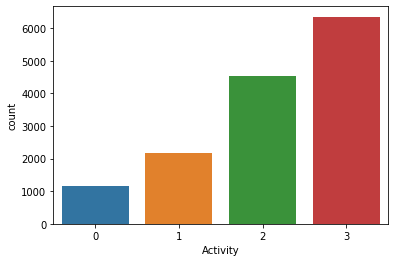

In [13]:
sns.countplot(x= "Activity",data= y_class)

## Baseline LGB Model

In [14]:
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature='auto')
dtest = lgb.Dataset(X_test, label=y_test, categorical_feature='auto')

In [15]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'max_cat_to_onehot': 4,
    'lambda_l1': 1,
    'lambda_l2': 1,
    'seed': 100,
    'num_class':4 
    
}

In [16]:
gbm = lgb.train(params,
                dtrain,
                num_boost_round=100,
                verbose_eval=100,
                valid_sets=[dtest, dtrain],  # eval training data
                )

[100]	training's multi_logloss: 0.174363	valid_0's multi_logloss: 0.182561


### Important Varibales base on Models

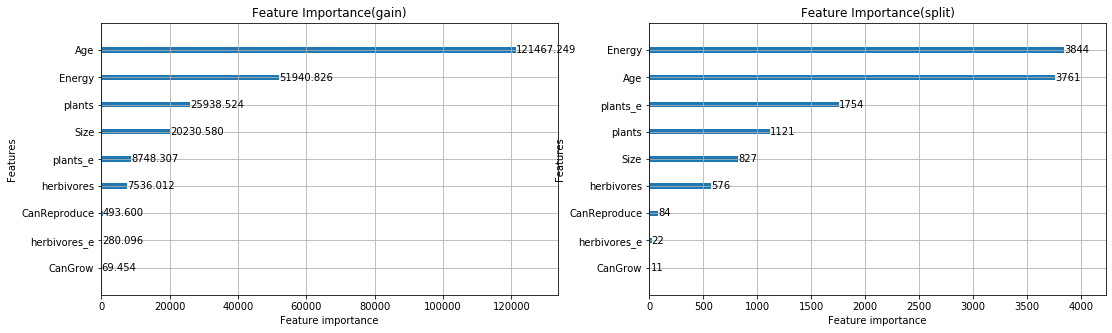

In [17]:
f, axs = plt.subplots(1, 2, figsize=(18, 5))
lgb.plot_importance(gbm, importance_type='gain', title='Feature Importance(gain)', ax=axs[0]);
lgb.plot_importance(gbm, importance_type='split', title='Feature Importance(split)', ax=axs[1]);

In [18]:
space4lgb = {
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.5),
    'num_leaves': pyll.scope.int(pyll.scope.maximum(hp.qlognormal('num_leaves', 4.5, 1, 1), 2)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    'feature_fraction_bynode': hp.uniform('feature_fraction_bynode', 0.5, 1),
    'min_data_in_leaf': pyll.scope.int(pyll.scope.maximum(hp.qlognormal('min_data_in_leaf', 4.5, 1, 1), 3)),
    'max_cat_to_onehot': pyll.scope.int(hp.quniform('max_cat_to_onehot', 4, 10, 1)),
    'lambda_l1': hp.lognormal('lambda_l1', 3, 2),
    'lambda_l2': hp.lognormal('lambda_l2', 3, 2),
    'max_bin': pyll.scope.int(pyll.scope.maximum(hp.qlognormal('max_bin', 6.5, 1, 1), 10)), 
}
pyll.stochastic.sample(space4lgb)

{'bagging_fraction': 0.9208050088813815,
 'feature_fraction': 0.6557461314275335,
 'feature_fraction_bynode': 0.5708075119492173,
 'lambda_l1': 11.229464510793546,
 'lambda_l2': 26.21147291514947,
 'learning_rate': 0.10122882042422289,
 'max_bin': 1347,
 'max_cat_to_onehot': 8,
 'min_data_in_leaf': 146,
 'num_leaves': 275}

In [19]:
best = {
    'bagging_fraction': 0.9503770158879287,
    'feature_fraction': 0.5857131468206892,
    'feature_fraction_bynode': 0.9120554269421401,
    'lambda_l1': 1.4689729868481995,
    'lambda_l2': 0.15467766956237552,
    'learning_rate': 0.10877675624568696,
    'max_bin': 75.0,
    'max_cat_to_onehot': 6.0,
    'min_data_in_leaf': 43.0,
    'num_leaves': 9.0}
space_eval(space4lgb, best)

{'bagging_fraction': 0.9503770158879287,
 'feature_fraction': 0.5857131468206892,
 'feature_fraction_bynode': 0.9120554269421401,
 'lambda_l1': 1.4689729868481995,
 'lambda_l2': 0.15467766956237552,
 'learning_rate': 0.10877675624568696,
 'max_bin': 75,
 'max_cat_to_onehot': 6,
 'min_data_in_leaf': 43,
 'num_leaves': 9}

In [20]:
default_params = {'boosting_type': 'gbdt',
                  'objective': 'multiclass',
                  'num_boost_round': 100,
                  'metric': 'multi_logloss',
                  'categorical_feature': 'auto',
                  'valid_sets': None,
                  'bagging_seed': 100,
                  'verbose': 0,
                  'seed': 100,
                  'num_class':4 
                  
                  }
params = {**default_params, **space_eval(space4lgb, best)}
del params['valid_sets'], params['num_boost_round']
params

{'boosting_type': 'gbdt',
 'objective': 'multiclass',
 'metric': 'multi_logloss',
 'categorical_feature': 'auto',
 'bagging_seed': 100,
 'verbose': 0,
 'seed': 100,
 'num_class': 4,
 'bagging_fraction': 0.9503770158879287,
 'feature_fraction': 0.5857131468206892,
 'feature_fraction_bynode': 0.9120554269421401,
 'lambda_l1': 1.4689729868481995,
 'lambda_l2': 0.15467766956237552,
 'learning_rate': 0.10877675624568696,
 'max_bin': 75,
 'max_cat_to_onehot': 6,
 'min_data_in_leaf': 43,
 'num_leaves': 9}

In [21]:
## Retraining the lgb model with best parameters:
gbm = lgb.train(params,
                dtrain,
                num_boost_round=1000,
                verbose_eval=10,
                valid_names=['eval', 'train'],
                valid_sets=[dtest, dtrain],  # eval training data
                early_stopping_rounds = 50
                )

Training until validation scores don't improve for 50 rounds
[10]	train's multi_logloss: 0.656111	eval's multi_logloss: 0.659668
[20]	train's multi_logloss: 0.480597	eval's multi_logloss: 0.484234
[30]	train's multi_logloss: 0.384941	eval's multi_logloss: 0.38854
[40]	train's multi_logloss: 0.336116	eval's multi_logloss: 0.339496
[50]	train's multi_logloss: 0.305132	eval's multi_logloss: 0.308309
[60]	train's multi_logloss: 0.284542	eval's multi_logloss: 0.287584
[70]	train's multi_logloss: 0.268108	eval's multi_logloss: 0.270802
[80]	train's multi_logloss: 0.256822	eval's multi_logloss: 0.259554
[90]	train's multi_logloss: 0.248107	eval's multi_logloss: 0.250945
[100]	train's multi_logloss: 0.23883	eval's multi_logloss: 0.24211
[110]	train's multi_logloss: 0.231339	eval's multi_logloss: 0.234925
[120]	train's multi_logloss: 0.224706	eval's multi_logloss: 0.228671
[130]	train's multi_logloss: 0.217671	eval's multi_logloss: 0.222007
[140]	train's multi_logloss: 0.211897	eval's multi_log

In [22]:
y_pred = gbm.predict(X_test)

## Computing SHAP Values

In [23]:
explainer = shap.TreeExplainer(model=gbm,
                               data=None,
                               model_output='raw',
                               feature_perturbation='tree_path_dependent')

In [24]:
shap_values = explainer.shap_values(X_test)

## Correlation Function
This function we will use for plotting Correlation between given class and Variables. Positive relation Variables show as Green and Negatively correlation shows in Red and no relation with Blue.

In [25]:
def ABS_SHAP(df_shap,df):

    #import matplotlib as plt

    # Make a copy of the input data

    shap_v = pd.DataFrame(df_shap)

    feature_list = df.columns

    shap_v.columns = feature_list

    df_v = df.copy().reset_index().drop('index',axis=1)

    

    # Determine the correlation in order to plot with different colors

    corr_list = list()

    for i in feature_list:

        b = np.corrcoef(shap_v[i],df_v[i])[1][0]

        corr_list.append(b)

    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)

    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient

    corr_df.columns  = ['Variable','Corr']
    
    
    corr_df['Sign'] = np.where(corr_df['Corr']>=0.3,'Green','blue')
    corr_df['Sign'][corr_df['Corr'] <-0.3] = 'red'
    

    # Plot it

    shap_abs = np.abs(shap_v)

    k=pd.DataFrame(shap_abs.mean()).reset_index()

    k.columns = ['Variable','SHAP_abs']

    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')

    k2 = k2.sort_values(by='SHAP_abs',ascending = True)

    colorlist = k2['Sign']

    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)

    ax.set_xlabel("SHAP Value (Red = Positive and Negative Impact)")

## (A) Variable Importance Plot — Global Interpretability
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples and uses SHAP values to show the distribution of the impacts each feature has on the model output.

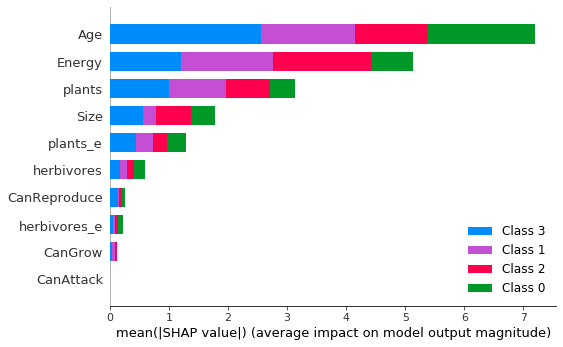

In [26]:
shap.summary_plot(shap_values, features=X_test, plot_type="bar")

As we can see the most important Feature is age and the second one is Energy.

We have Four classes so we have Four List of SHAP Values which we can Access by shap_values[0] for 0 class and shap_values[1] for class one and so on. If We provide a single set of SHAP values to shap.summary_plot() then it creates a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output and show the positive and negative relationships of the predictors with the target variable.

#### Activity Zero

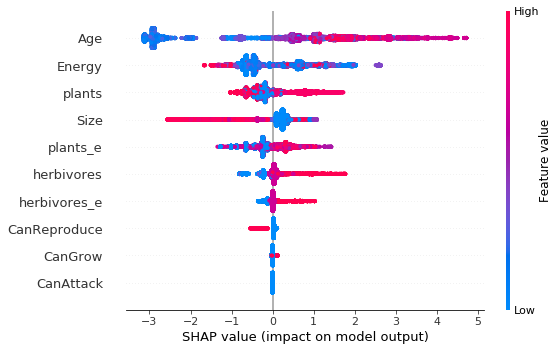

In [27]:
shap.summary_plot(shap_values[0], features=X_test)

This plot is made of all the dots in the test data. As we can see Age has a high and positive relation with Activity. The “high” comes from the red color, and the “positive” impact comes from positive shape values on the horizontal line. The horizontal Line (SHAP Values) shows whether the effect of that value is associated with a higher or lower prediction. 

We are not clear about Energy and Plant attributes We will be clear as we move forward. Size is negatively correlated as we can clearly see it has negative SHAP values.

## Simplified plot
We will use a plot that will show a simplified version of the above plot for easier interpretation. It highlights the correlations in colors. The Green color means a feature is positively correlated with the target variable and Negative Correlated with REd. Blue color shows no correlation.

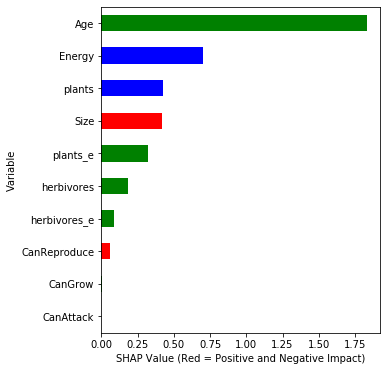

In [28]:
ABS_SHAP(shap_values[0],X_test)

Now we can easily interpret each variable correlation. Age, plants_e ,herbovores and herbovores_e is possitively correlated and size and can reproduce is negative correlated. 


#### Activity One

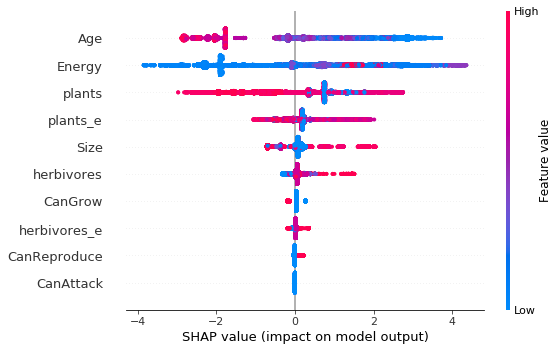

In [29]:
shap.summary_plot(shap_values[1], features=X_test)

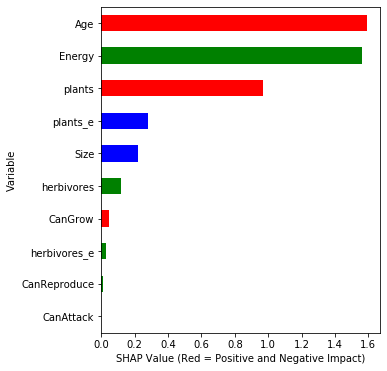

In [30]:
ABS_SHAP(shap_values[1],X_test)

Here age and plants are negative correlated and Energy, herbovores and herbovores_e are possitive correlated.

#### Activity Two

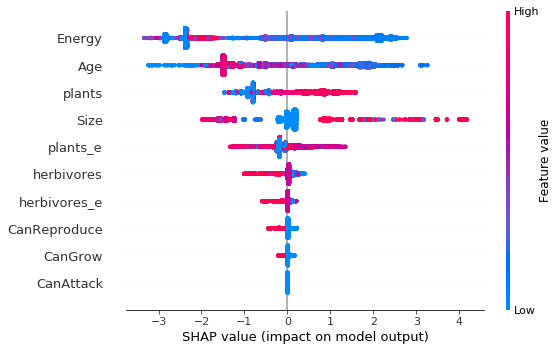

In [31]:
shap.summary_plot(shap_values[2], features=X_test)

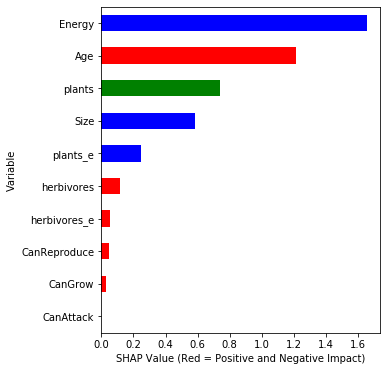

In [32]:
ABS_SHAP(shap_values[2],X_test)

For Activity 2 Plants is possitively correlated and age, plants_e ,herbovores, herbovores_e, CanGrow and CanReproduce are negative correlated.

#### Activity Three

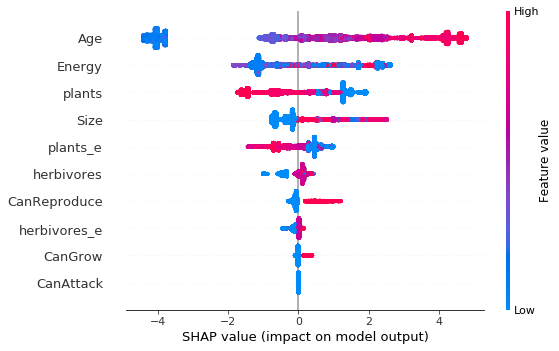

In [33]:
shap.summary_plot(shap_values[3], features=X_test)

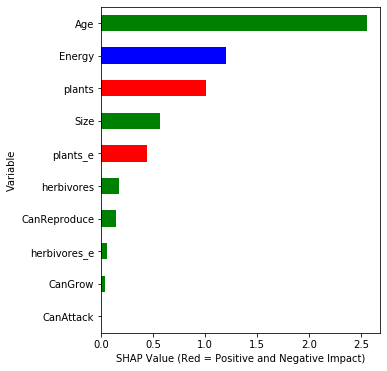

In [34]:
ABS_SHAP(shap_values[3],X_test)

As we can see For Activity 3 Age, Size, plants_e, herbivores, herbovores_e, CanGrow, and CanReproduce are positively correlated ad plants and plants_e are negatively correlated.

# (B) SHAP Dependence Plot — Global Interpretability

The partial dependence plot shows the marginal effect one or two features have on the predicted outcome of a machine learning model. It tells whether the relationship between the target and a feature is linear, monotonic.

SHAP can also select the interaction variable For coloring that seems to have the strongest interaction with the main variable. Let's create a SHAP dependence plot for the top 2 features with the highest impact on the model.

Note: In this graph, X-axis has the original values of age, and Y-axis has SHAP values of Age. If we have higher the Positive SHAP Values so it has Higher the impact on model output in positive Direction. Higher Negative Values pushing the model output in Negative Direction. You will know about what is mean by positive Direction and Negative Direction in a single prediction.

## Activity Zero

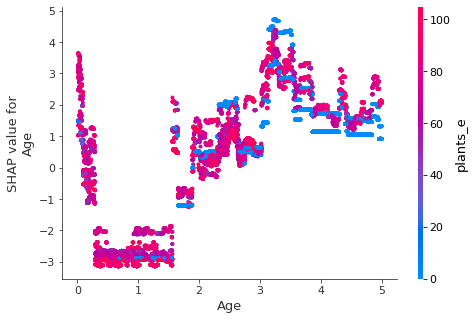

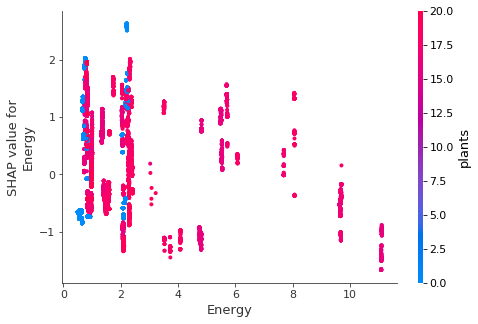

In [35]:
top_inds = np.argsort(-np.sum(np.abs(shap_values[0]), 0))
# make SHAP plots of the three most important features
for i in range(2):
    shap.dependence_plot(top_inds[i], shap_values[0], features=X_test, display_features=X_test)

As we can see these are not linear functions that we can easily interpret. These are complex non-linear functions. As we can at the start as age values are increasing it is negatively correlated and then it positively correlated as age increasing. The energy function is more complex from age . its decrease and increase as Energy values are increasing.

NOte: We will interpret these functions in detail in random forest File with another Library.

## Activity One

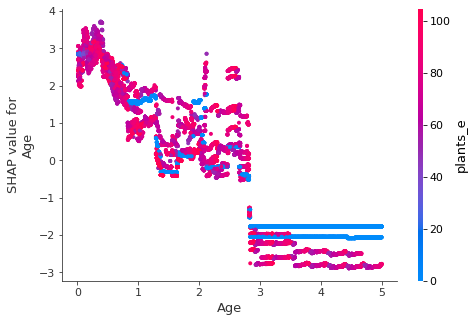

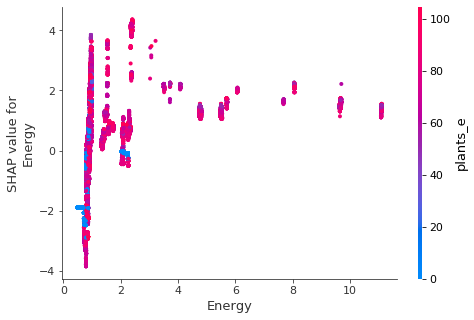

In [36]:
top_inds = np.argsort(-np.sum(np.abs(shap_values[1]), 0))
for i in range(2):
    shap.dependence_plot(top_inds[i], shap_values[1], features=X_test, display_features=X_test)

These graphs are easier to understand. But these are not linear function we can easily interpret but we can see that age is negative and Energy is positive correlated.

## Activity Two

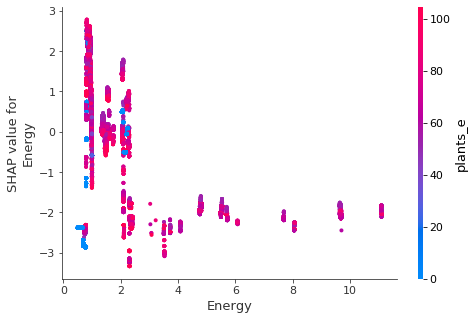

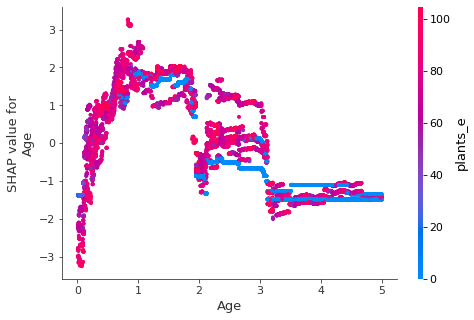

In [37]:
top_inds = np.argsort(-np.sum(np.abs(shap_values[2]), 0))
for i in range(2):
    shap.dependence_plot(top_inds[i], shap_values[2], features=X_test, display_features=X_test)

As we can clearly see for age as age values increase SHAP Values are moving toward Negative to Positive direction but then it starts decreasing again and we are not clear about Energy Plot. But We will see this function Random Forest Notebook.

## Activity Three

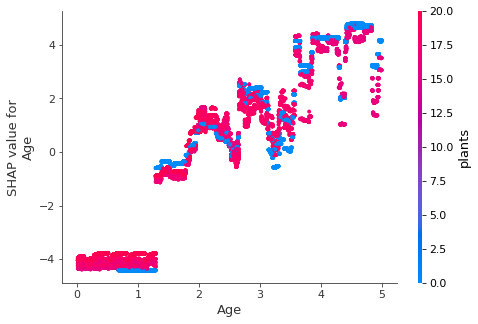

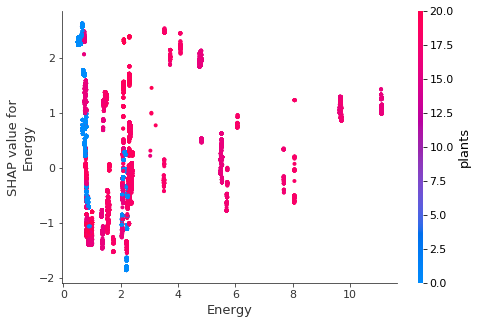

In [38]:
top_inds = np.argsort(-np.sum(np.abs(shap_values[3]), 0))
for i in range(2):
    shap.dependence_plot(top_inds[i], shap_values[3], features=X_test, display_features=X_test)

As we clearly see these are complex non linear function we will talk about these functions in RF file.

### Explaining  single prediction
Before Explaining Single Prediction. First we will know about how our model is predicting.

In [39]:
y_pred = gbm.predict(X_test)

This cmd predicting the probability of each Activity. It tells which activity has the highest Proabiblty Value. We have 4 Activity so our model predicting 4 values for every single example. Let's check the Value for the first Example.

In [40]:
 
print(np.round(y_pred,3)[0])

[0.    0.009 0.991 0.   ]


As we can see Activity two has highest probability.

But SHAP Libarary uses Raw Out of model instead of Probability. Let's check what is the Raw output.

In [41]:
print(np.round(gbm.predict(X_test, raw_score=True)[0]))

[-6. -3.  2. -6.]


As we are seeing Raw outputs of model but Activity 2 is hights Value.

Why the Model output is negative ? Because values you are seeing are log odds values. for More clarification check these two links.
1. https://github.com/slundberg/shap/issues/29
2. https://github.com/slundberg/shap/issues/367#issuecomment-508575308

Let's check what is orignal output of this example and what is the Probability our model predicting and Raw Model value before Ploting graph.

In [42]:
print(f'True value : {y_test.iloc[1]}')
max_ = np.argmax(y_pred[1])
print("Our prediction: ",max_)
print(f'Probability : {round(y_pred[1][max_],4)}')
print(f'Raw model prediction (logit) : {gbm.predict(X_test, raw_score=True)[1]}')

True value : 1
Our prediction:  1
Probability : 0.9942
Raw model prediction (logit) : [-5.57444288  1.12870296 -4.26562265 -9.76136704]


In [43]:
shap.initjs()
shap.force_plot(explainer.expected_value[max_], shap_values[max_][1,:], features=X_test.iloc[1, :])

Let's Interpret these results. Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue. We will see what are the shap values of this example so we can check why plants pushing the predicion in lower and other Value in positive.

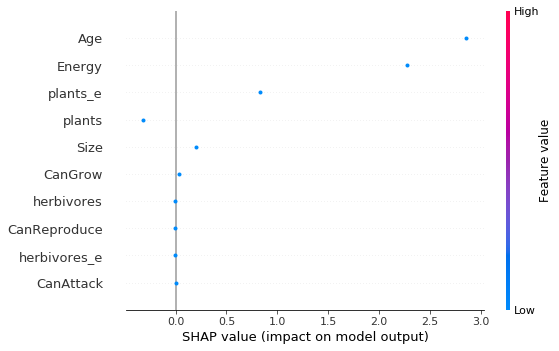

In [44]:
shap.summary_plot(shap_values[max_][1:2,:], features=X_test.iloc[1:2,:])

As we can see Age has the highest positive value which is pushing the prediction Higher and Plants has Negative SHAP value which pushing the prediction Lower.

Let's Check another Example. First Display orignal output of this example and what is the Probability our model predicting and Raw Model value.

In [45]:
print(f'True value : {y_test.iloc[13]}')
max_ = np.argmax(y_pred[13])
print("Our prediction: ",max_)
print(f'Probability : {round(y_pred[13][max_],4)}')
print(f'Raw model prediction (logit) : {gbm.predict(X_test, raw_score=True)[13]}')

True value : 3
Our prediction:  3
Probability : 0.9995
Raw model prediction (logit) : [-4.03248442 -7.30412332 -8.35372107  3.65146147]


In [46]:
shap.force_plot(explainer.expected_value[max_], shap_values[max_][13,:], features=X_test.iloc[13, :])

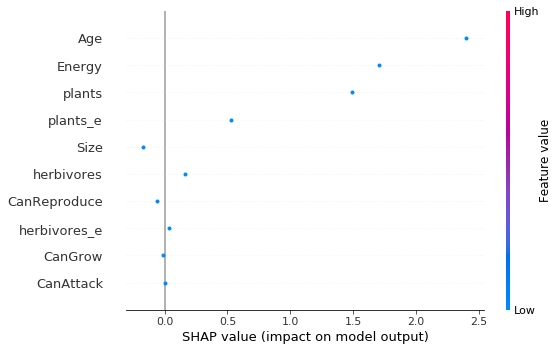

In [47]:
shap.summary_plot(shap_values[max_][13:14,:], features=X_test.iloc[13:14,:])

As we can see Size and canReproduce pushing it lower with lower negative values and all other attributes pushing it high and canGrow and can attack has lower shap Values.

In [48]:
print(f'True value : {y_test.iloc[11]}')
max_ = np.argmax(y_pred[11])
print("Our prediction: ",max_)
print(f'Probability : {round(y_pred[11][max_],4)}')
print(f'Raw model prediction (logit) : {gbm.predict(X_test, raw_score=True)[13]}')

True value : 0
Our prediction:  0
Probability : 0.6035
Raw model prediction (logit) : [-4.03248442 -7.30412332 -8.35372107  3.65146147]


In [49]:
shap.force_plot(explainer.expected_value[max_], shap_values[max_][11,:], features=X_test.iloc[11, :])

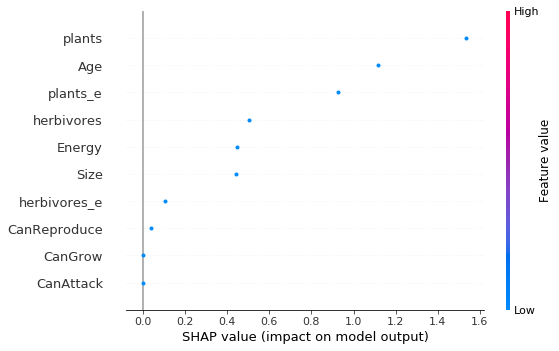

In [50]:
shap.summary_plot(shap_values[max_][11:12,:], features=X_test.iloc[11:12,:])

In this Plot all the values pushing it Higher, and Plants has the highest impact on model output.

In [51]:
print(f'True value : {y_test.iloc[1500]}')
max_ = np.argmax(y_pred[1500])
print("Our prediction: ",max_)
print(f'Probability : {round(y_pred[1500][max_],4)}')
print(f'Raw model prediction (logit) : {gbm.predict(X_test, raw_score=True)[1500]}')

True value : 3
Our prediction:  3
Probability : 0.5989
Raw model prediction (logit) : [-0.85759672 -5.84807202 -8.24247809 -0.44932895]


In [52]:
shap.force_plot(explainer.expected_value[max_], shap_values[max_][1500,:], features=X_test.iloc[1500, :])

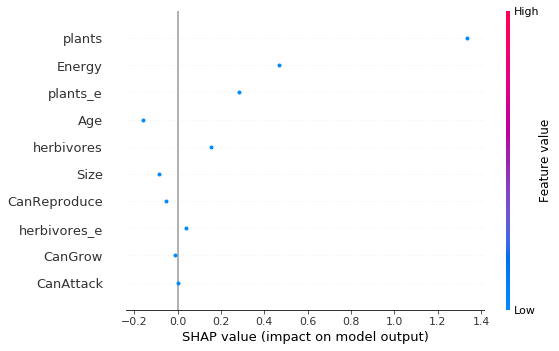

In [53]:
shap.summary_plot(shap_values[max_][1500:1501,:], features=X_test.iloc[1500:1501,:])

Age, Size and CanReproudce are pushing this in lower and other remaining features pushing it higher.

In [54]:
print(f'True value : {y_test.iloc[10]}')
max_ = np.argmax(y_pred[10])
print("Our prediction: ",max_)
print(f'Probability : {round(y_pred[10][max_],4)}')
print(f'Raw model prediction (logit) : {gbm.predict(X_test, raw_score=True)[10]}')

True value : 2
Our prediction:  2
Probability : 0.9911
Raw model prediction (logit) : [-1.71057786 -7.11028343  3.08054607 -4.28866354]


In [55]:
shap.force_plot(explainer.expected_value[max_], shap_values[max_][10,:], features=X_test.iloc[10, :])

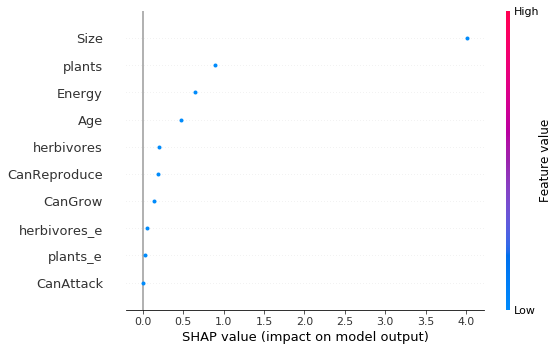

In [56]:
shap.summary_plot(shap_values[max_][10:11,:], features=X_test.iloc[10:11,:])

In This Example Size is most important with highest SHAP values and ALL variable are pushing it higher.